In [517]:
%pylab inline
import scipy as sp
import pandas as pd
autumn();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [566]:
data = pd.read_csv('in.csv', index_col=0)
data.head(3)

,a,b,c,d,e
id,,,,,
1,7906633,20,130,0,483
2,NaN,NaN,70,NaN,152
3,19122621,642,20,13283,NaN


In [519]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.dropna())

0    179
1    187
2     65
3      8
dtype: int64

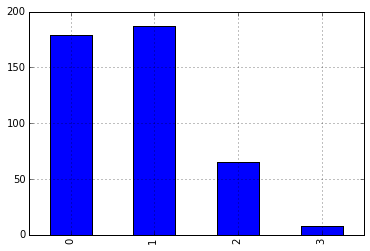

In [520]:
missing_values = data.isnull().sum(axis=1)
missing_groups = missing_values.groupby(missing_values.values).size()
missing_groups.plot(kind='bar')
missing_groups

In [521]:
data.describe()

,a,b,c,d,e
count,350.000000,375.000000,368.000000,404.000000,357.000000
mean,1931520.328571,872379.480000,2188.179348,46544.349010,35593.725490
std,3706373.503441,2957194.665734,4620.451613,21411.213027,181819.857097
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,111216.250000,6415.500000,130.000000,32090.250000,132.000000
50%,632400.000000,32700.000000,475.000000,44939.500000,784.000000
75%,1970495.750000,222177.500000,1800.000000,60289.250000,2516.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


In [522]:
extended_data = data.copy()
for c in extended_data.columns:
    extended_data["log_{}".format(c)] = np.log(1 + data[c])

In [523]:
data.shape

(439, 5)

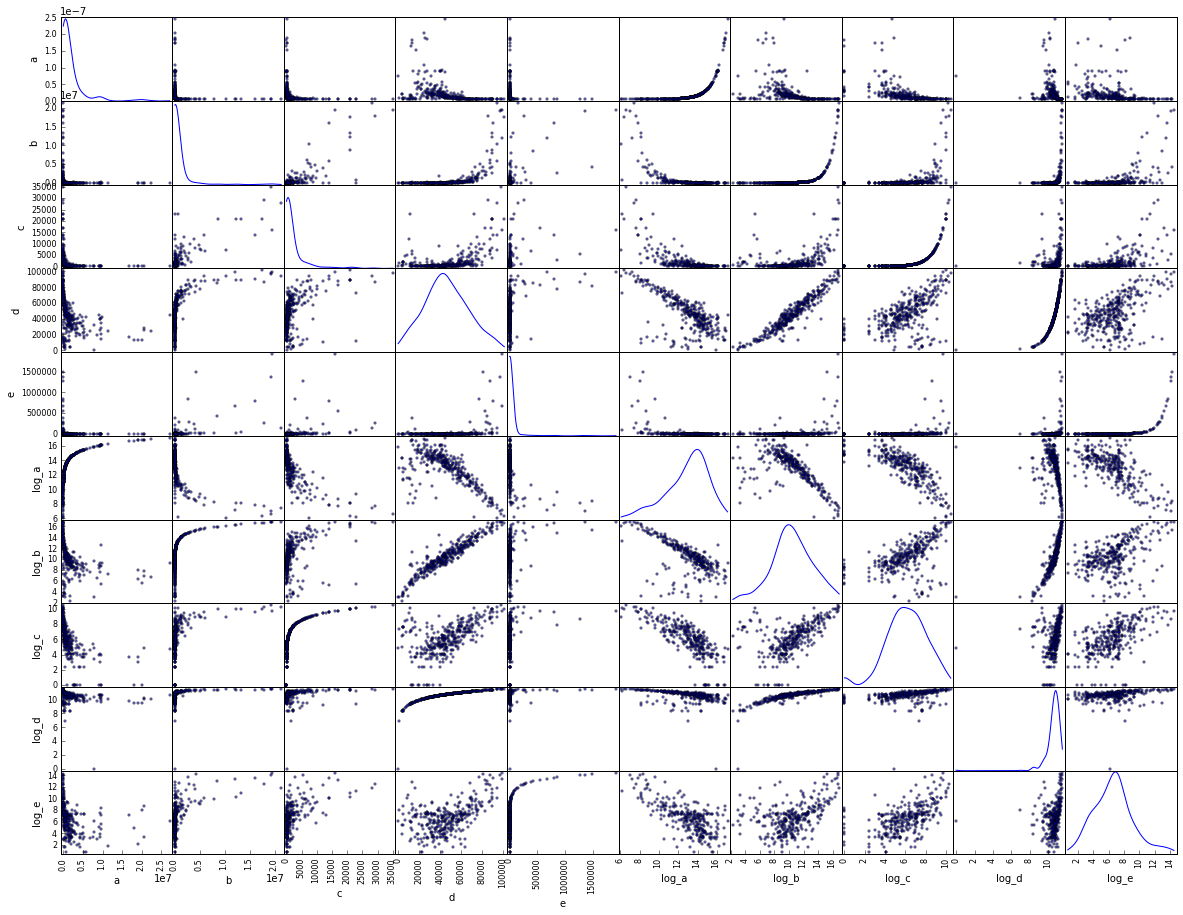

In [524]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(extended_data, figsize=(20, 15), diagonal='kde');

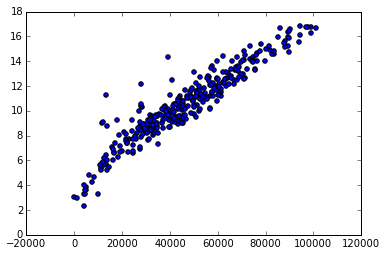

In [525]:
scatter(extended_data.d, extended_data.log_b);

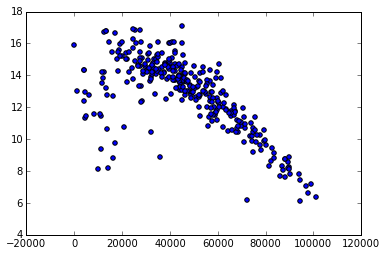

In [526]:
scatter(extended_data.d, extended_data.log_a);

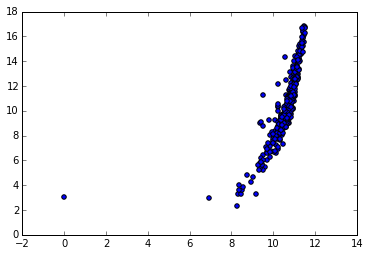

In [527]:
scatter(extended_data.log_d, extended_data.log_b);

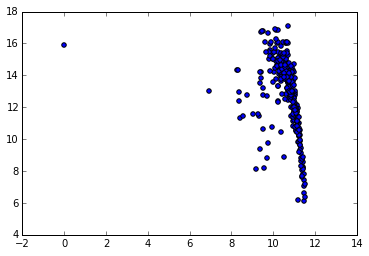

In [528]:
scatter(extended_data.log_d, extended_data.log_a);

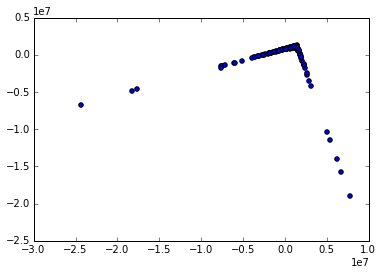

In [529]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data.dropna())
scatter(*(data_2d.T));

In [530]:
pca.explained_variance_ratio_.sum()

0.99962555452385982

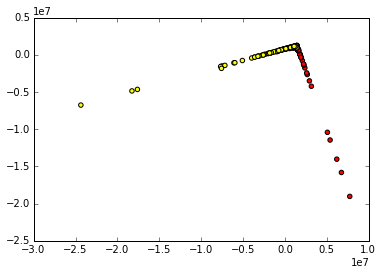

In [531]:
joint_idx = data_2d.argmax(axis=0)[1]
joint = data_2d[joint_idx]
branch_idx = (data_2d[:, 0] < joint[0])
scatter(*(data_2d.T), c=branch_idx);

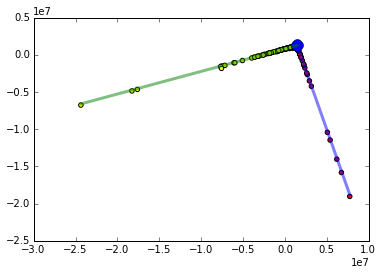

In [532]:
from sklearn.linear_model import LinearRegression
branches = [LinearRegression() for _ in [0, 1]]
scatter(*(data_2d.T), c=branch_idx);
plot(joint[0], joint[1], 'bo', markersize=12)
directions = []
for idx, branch in enumerate(branches):
    points = data_2d[branch_idx == idx]
    branch.fit(points[:, 0, np.newaxis], points[:, 1, np.newaxis])
    dx = (points[:, 0].max() - points[:, 0].min()) * [1, -1][idx]
    dy = branch.coef_ * dx
    directions.append(np.array((dx, dy), dtype=float))
    plot((joint[0], joint[0] + dx),
         (joint[1], joint[1] + dy),
         linewidth=3,
         alpha=0.5);

In [533]:
directions

[array([  6290814.7204772 , -20050770.97187498]),
 array([-25827404.94008032,  -7855792.5502958 ])]

In [534]:
initial_center = pca.inverse_transform(joint)
initial_directions = [pca.inverse_transform(i) for i in directions]

In [535]:
initial_directions

[array([  1705616.13070135,  21780065.57442008,     30426.32993618,
           120009.52858987,    362198.89296095]),
 array([  2.87761285e+07,   6.29836123e+05,  -1.85603967e+03,
          3.44091942e+03,  -9.36307422e+03])]

In [536]:
initial_center

array([  6506.07284097,   2237.70351374,   1373.64749769,  45781.33820179,
         9371.19896322])

In [538]:
array([])

array([], dtype=float64)

In [126]:
p = data.dropna().iloc[10]

In [127]:
p

a    547348
b     40330
c       425
d     45192
e       581
Name: 39, dtype: float64

In [128]:
def project(vector, direction):
    return vector.dot(direction) / direction.dot(direction)
def MSE(x, y):
    d = x - y
    return d.dot(d)
k = [project(p - initial_center, i) for i in initial_directions]

In [129]:
[(p - initial_center) / i for i in initial_directions]

[a    0.317095
 b    0.001749
 c   -0.031179
 d   -0.004911
 e   -0.024269
 Name: 39, dtype: float64, a    0.018795
 b    0.060480
 c    0.511114
 d   -0.171273
 e    0.938815
 Name: 39, dtype: float64]

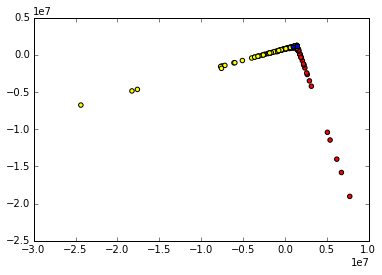

In [130]:
new_p = [(a * b + initial_center) for a, b in zip(k, initial_directions)]
scatter(*(data_2d.T), c=branch_idx);
scatter(*(pca.transform(new_p).T), marker="s");
scatter(*(pca.transform(p).T), marker="p");

In [590]:
def project(vector, direction):
    return vector.dot(direction) / direction.dot(direction)
def MSE(x, y):
    d = x - y
    return d.dot(d)

class Filler:
    def __init__(self):
        self._center = array([6506.07284097,
                              2237.70351374,
                              1373.64749769,
                              45781.33820179,
                              9371.19896322])
        self._directions = [array([1705616.13070135,
                                   21780065.57442008,
                                   30426.32993618,
                                   120009.52858987,
                                   362198.89296095]),
                            array([2.87761285e+07,
                                   6.29836123e+05,
                                   -1.85603967e+03,
                                   3.44091942e+03,
                                   -9.36307422e+03])]
    def predict_point(self, point):
        mask = ~np.isnan(point)
        filled_point = np.nan_to_num(point)
        projections = [project(filled_point - self._center * mask,
                               direction * mask) 
                       for direction in self._directions]
        predictions = [projection * direction + self._center
                       for projection, direction in zip(projections, self._directions)]
        errors = [MSE(prediction * mask, filled_point) 
                  for prediction in predictions]
        prediction = predictions[np.argmin(errors)]
        prediction[prediction < 0] = 0
        return filled_point * mask + prediction * ~mask
    def predict(self, X):
        answer = np.zeros(X.shape)
        for idx, point in enumerate(X):
            answer[idx] = self.predict_point(point)
        return answer

def get_test_data(data, threshold):
    result = data.copy().astype(float)
    result.iloc[np.random.sample(result.shape) < threshold] = np.NaN
    return result

def test_filler(filler, data, threshold):
    answer = data
    test_data = get_test_data(data, threshold)
    filler_answer = filler.predict(test_data.values)
    return ((filler_answer - answer)**2).mean()
    
f = Filler()
f.predict_point(p)
train_data = data.dropna()
test_filler(f, train_data, threshold=0.33)
p = data.ix[1].copy()
print(p)
p[1] = np.nan
print(f.predict_point(p))

a    7906633
b         20
c        130
d          0
e        483
Name: 1, dtype: float64
a    7906633.000000
b     175151.273887
c        130.000000
d          0.000000
e        483.000000
Name: 1, dtype: float64


0.2:  
a    7.223557e+12  
b    2.179779e+12  
c    5.294718e+05  
d    5.776310e+07  
e    8.574578e+08  

In [592]:
prediction.describe()

,0,1,2,3,4
count,260.000000,260.000000,260.000000,260.000000,260.000000
mean,3985465.744746,777758.985005,2300.017633,47168.105661,42653.675345
std,10898496.272211,2720646.141247,4534.110759,20280.244964,199717.596532
min,0.000000,0.000000,0.000000,4220.000000,0.000000
25%,72566.677319,5423.750000,207.500000,34602.000000,375.750000
50%,621068.500000,25999.901758,752.996002,45830.452925,1665.000000
75%,2127221.250000,213228.235516,1700.000000,59270.500000,9245.563320
max,80734903.513993,19349337.000000,35000.000000,101295.000000,1918620.000000


In [585]:
data.ix[missing_values == 0].describe()

,a,b,c,d,e
count,179.000000,179.000000,179.000000,179.000000,179.000000
mean,1780825.608939,768670.156425,2153.324022,45738.396648,20062.994413
std,3421357.809584,2797727.030679,4609.981170,21028.638705,95588.283493
min,481.000000,9.000000,0.000000,0.000000,1.000000
25%,120065.500000,8116.000000,115.000000,32057.500000,88.500000
50%,596662.000000,35356.000000,500.000000,45192.000000,689.000000
75%,1839045.000000,202182.500000,1800.000000,59616.500000,2524.000000
max,27057179.000000,21245399.000000,29000.000000,94377.000000,846185.000000


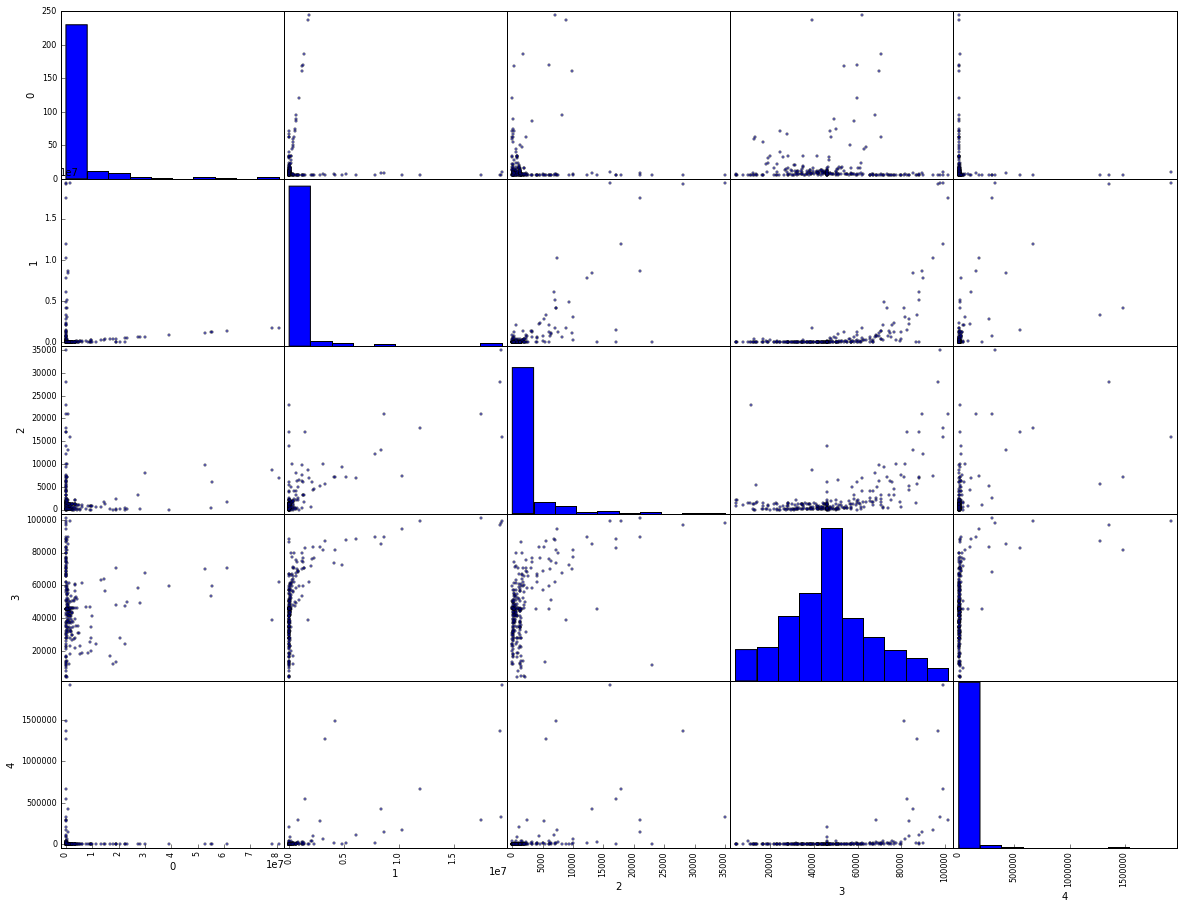

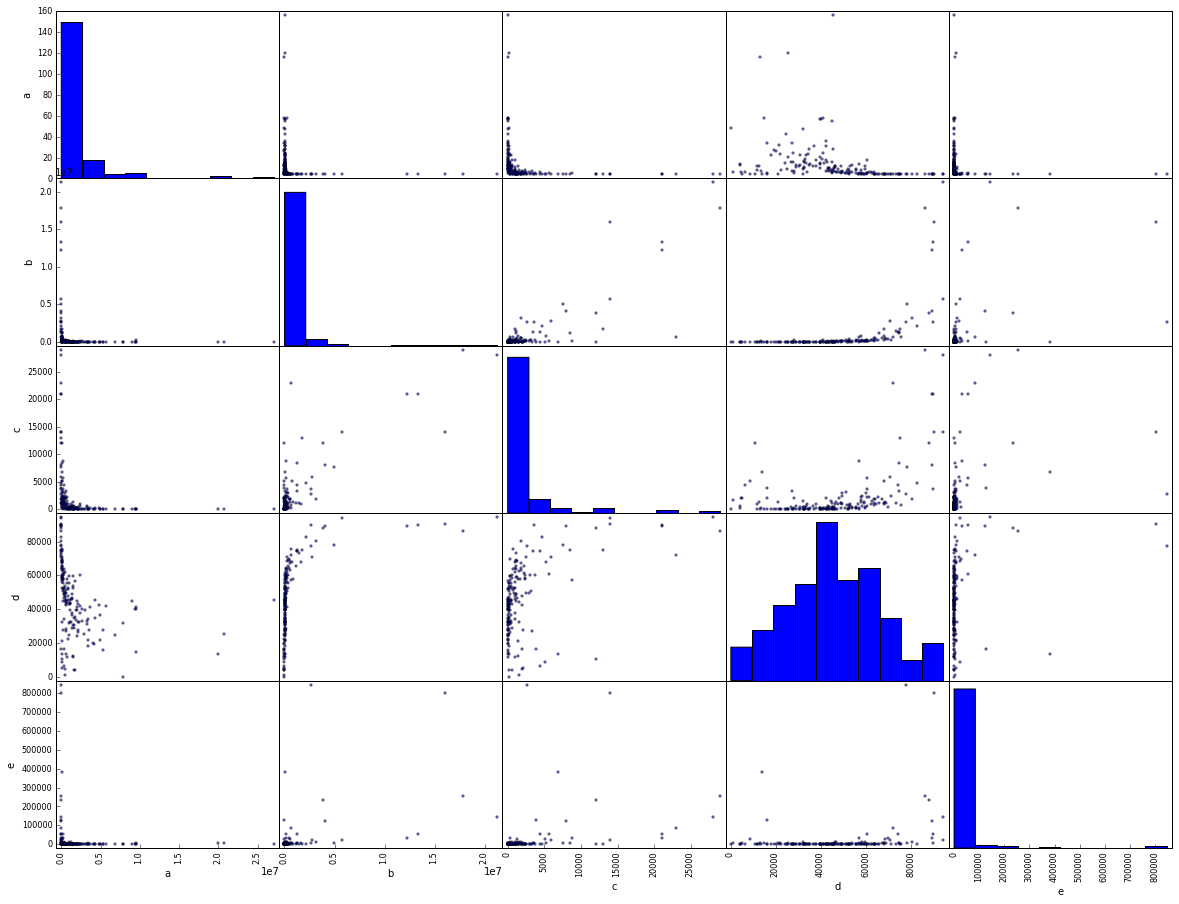

In [593]:
prediction = pd.DataFrame(f.predict(data.ix[missing_values > 0].values))
scatter_matrix(prediction, figsize=(20, 15));
show()
scatter_matrix(data.ix[missing_values == 0], figsize=(20, 15));

In [542]:
p

a    NaN
b    NaN
c     70
d    NaN
e    152
Name: 2, dtype: float64

In [131]:
p

a    547348
b     40330
c       425
d     45192
e       581
Name: 39, dtype: float64

In [132]:
new_p

[array([ 12753.82800104,  82019.14708105,   1485.10062975,  46220.93896424,
         10697.95119178]),
 array([ 547925.15430825,   14087.98753568,    1338.72635477,
          45846.07864913,    9195.03395029])]

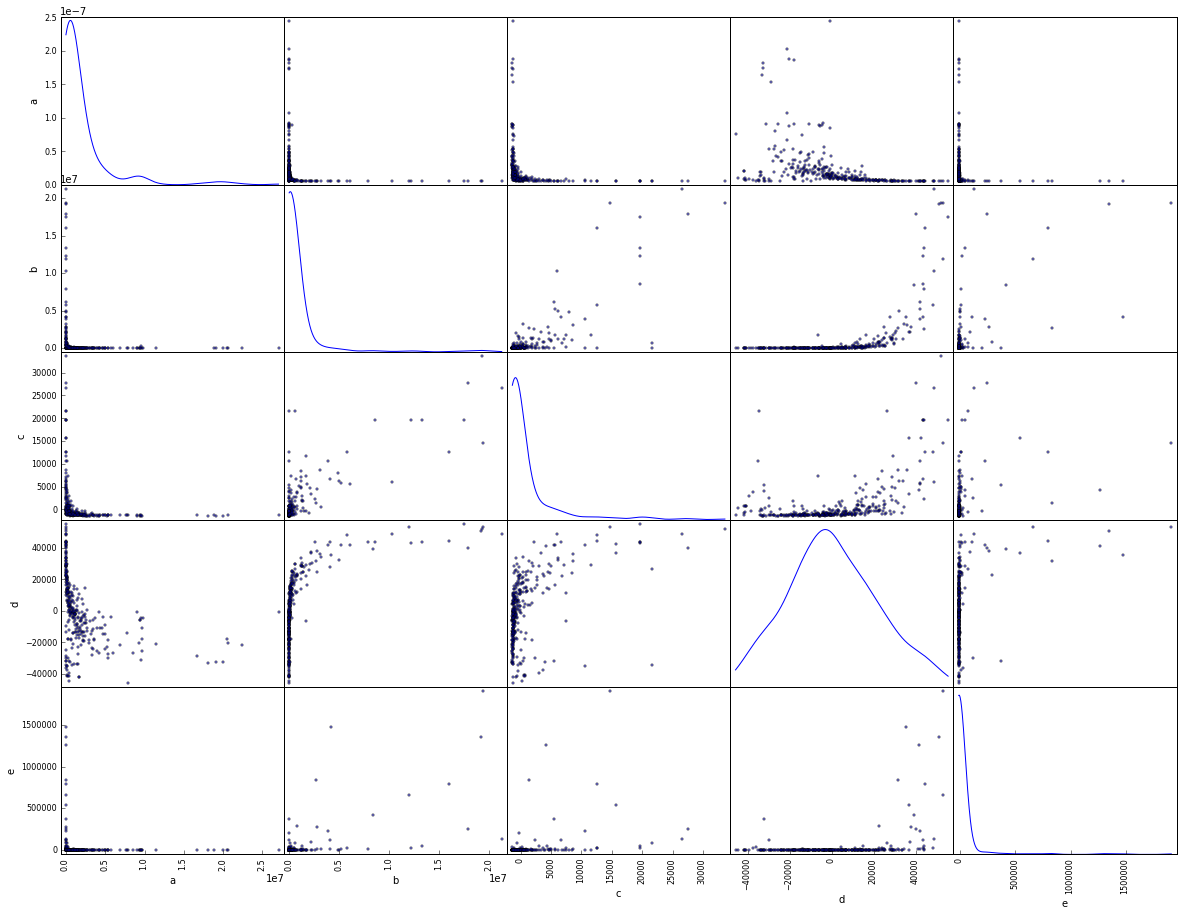

In [133]:
scatter_matrix(data - initial_center, figsize=(20, 15), diagonal='kde');

In [134]:
pca.components_

array([[ -9.55204997e-01,   2.95877296e-01,   5.33243525e-04,
          2.52354899e-03,   5.77804862e-03],
       [ -2.95939153e-01,  -9.55079792e-01,  -1.24276866e-03,
         -2.91240436e-03,  -1.52506487e-02]])

In [135]:
data.ix[~np.isnan(data.d)].describe()

,a,b,c,d,e
count,319.000000,345.000000,336.000000,404.000000,326.000000
mean,1927813.620690,928299.118841,2240.863095,46544.349010,37759.674847
std,3706390.875144,3066270.954140,4738.107406,21411.213027,189756.128372
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,104323.000000,7367.000000,137.500000,32090.250000,132.000000
50%,622070.000000,33046.000000,475.000000,44939.500000,802.000000
75%,1965439.500000,274050.000000,1850.000000,60289.250000,2528.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


In [136]:
data.ix[np.isnan(data.d)].describe()

,a,b,c,d,e
count,31.000000,30.000000,32.000000,0,31.000000
mean,1969663.548387,229303.633333,1635.000000,NaN,12816.322581
std,3767239.954894,887671.369678,3129.283129,NaN,40331.230109
min,7992.000000,27.000000,0.000000,NaN,4.000000
25%,324202.000000,3315.750000,107.500000,NaN,156.500000
50%,697847.000000,22107.000000,337.500000,NaN,661.000000
75%,1732257.500000,48330.750000,1150.000000,NaN,1817.500000
max,18896128.000000,4834455.000000,14000.000000,NaN,209374.000000
